In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [3]:
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [4]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [5]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

In [6]:
# load resnetv2 model
model = ResNet50V2()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

102869336/102869336 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [7]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [8]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [9]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [10]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [11]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [12]:
len(mapping)

8091

In [29]:
features['1000268201_693b08cb0e'].shape

(1, 2048)

In [13]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [14]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [15]:
# preprocess the text
clean(mapping)

In [16]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [17]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [18]:
len(all_captions)

40455

In [19]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [20]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [21]:
vocab_size

8485

In [22]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [23]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [24]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

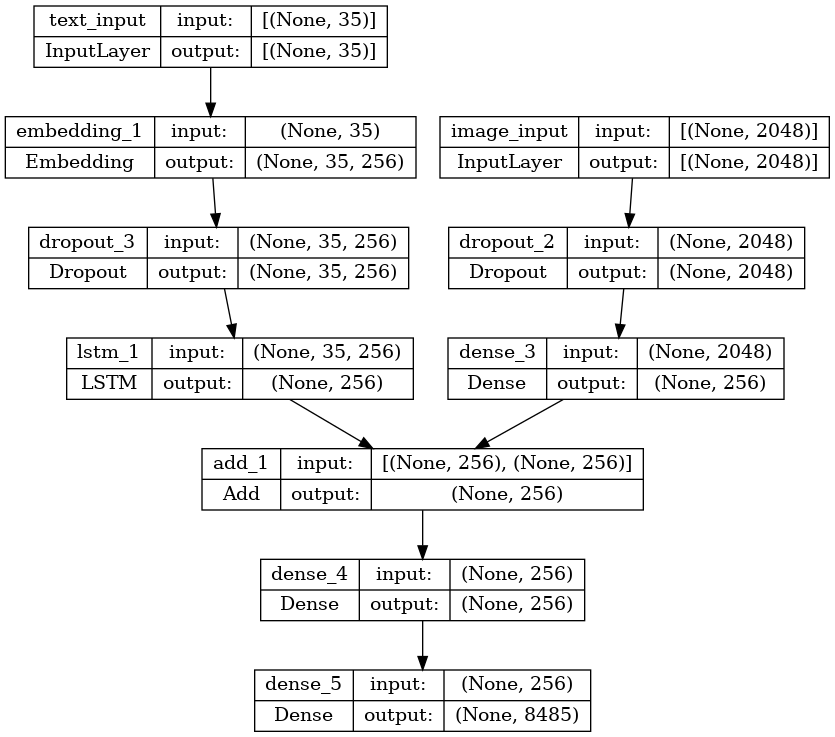

In [30]:
# encoder model
# image feature layers
inputs1 = Input(shape=(2048,), name="image_input")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text_input")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [31]:
# train the model
epochs = 15
batch_size = 32
steps = len(train) // batch_size

# for i in range(epochs):
#     # create data generator
generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
# fit for one epoch
history = model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/15
227/227 [==============================] - 85s 345ms/step - loss: 5.2837
Epoch 2/15
227/227 [==============================] - 66s 290ms/step - loss: 4.0417
Epoch 3/15
227/227 [==============================] - 64s 281ms/step - loss: 3.6223
Epoch 4/15
227/227 [==============================] - 63s 278ms/step - loss: 3.3673
Epoch 5/15
227/227 [==============================] - 63s 278ms/step - loss: 3.1771
Epoch 6/15
227/227 [==============================] - 63s 278ms/step - loss: 3.0229
Epoch 7/15
227/227 [==============================] - 63s 275ms/step - loss: 2.8997
Epoch 8/15
227/227 [==============================] - 62s 273ms/step - loss: 2.7968
Epoch 9/15
227/227 [==============================] - 62s 274ms/step - loss: 2.7064
Epoch 10/15
227/227 [==============================] - 62s 273ms/step - loss: 2.6310
Epoch 11/15
227/227 [==============================] - 62s 274ms/step - loss: 2.5646
Epoch 12/15
227/227 [==============================] - 63s 276ms/step - lo

In [32]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [33]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [34]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [53]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu

In [35]:
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    

In [39]:
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.2, 0.3, 0.5, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.528987
BLEU-2: 0.317000
BLEU-3: 0.151570
BLEU-4: 0.123732


In [63]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    print("BLEU-1: %f" % sentence_bleu(captions, y_pred, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % sentence_bleu(captions, y_pred,  weights=(0.5, 0.5, 0, 0)))
    print("BLEU-3: %f" % sentence_bleu(captions, y_pred,  weights=(0.2, 0.3, 0.5, 0)))
    print("BLEU-4: %f" % sentence_bleu(captions, y_pred,  weights=(0.25, 0.25, 0.25, 0.25)))
    plt.figure()
    plt.imshow(image)

In [69]:
def gen_rand_cap():
    id = np.random.randint(0,len(mapping))
    filepaths = os.listdir(BASE_DIR +"/Images")
    sample_path = filepaths[id] 
    generate_caption(sample_path)

---------------------Actual---------------------
startseq boy surfs endseq
startseq young boy rides on surfboard with light blue water behind him endseq
startseq young male surfing endseq
startseq young surfer surfs the large blue wave endseq
startseq young boy surfing on blue water endseq
--------------------Predicted--------------------
startseq man in black and white wetsuit is riding wave endseq
BLEU-1: 0.885246
BLEU-2: 0.777765
BLEU-3: 0.588923
BLEU-4: 0.541394


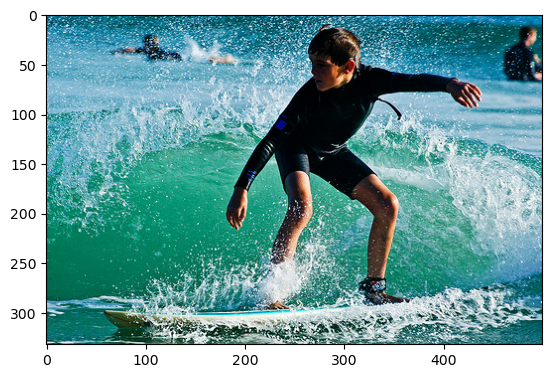

In [70]:
gen_rand_cap()

---------------------Actual---------------------
startseq boy in an orange jersey is about to pitch baseball endseq
startseq "a boy in an orange "" spring hill "" ball team uniform pitching the ball ." endseq
startseq little boy in orange pitching at baseball game endseq
startseq young boy in an orange uniform is pitching baseball during game endseq
startseq the boy in the orange shirt is throwing the ball endseq
--------------------Predicted--------------------
startseq baseball player in red uniform is about to kick the ball endseq
BLEU-1: 0.972222
BLEU-2: 0.875684
BLEU-3: 0.790438
BLEU-4: 0.781212


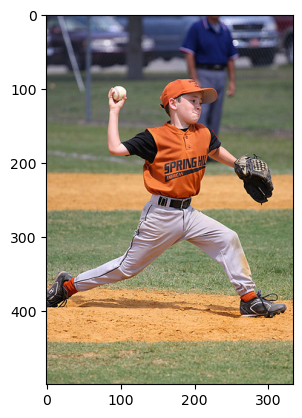

In [71]:
gen_rand_cap()

---------------------Actual---------------------
startseq girl wearing blue top has her feet in the stream endseq
startseq hiker puts his feet in stream while wearing brown shoes endseq
startseq man wearing blue shirt and shorts is resting on rock soaking his feet in rocky stream endseq
startseq person is sitting near smooth rocks on stream bed endseq
startseq "a woman dressed in blue shirt plaid shorts and brown shoes soaking her feet in rocky creek while sitting on towel ." endseq
--------------------Predicted--------------------
startseq woman in red shirt and white t shirt is sitting on rocks in the sand endseq
BLEU-1: 0.988095
BLEU-2: 0.944911
BLEU-3: 0.868200
BLEU-4: 0.820161


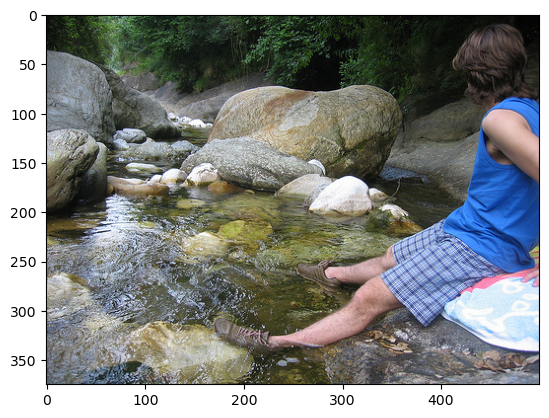

In [72]:
gen_rand_cap()

---------------------Actual---------------------
startseq two girls holding another girl wearing yellow top in room with tan carpet endseq
startseq two girls hold up another girl and smile for the camera endseq
startseq two girls hold up their younger sister endseq
startseq two girls lift third girl endseq
startseq two older girls hold younger girl between them indoors endseq
--------------------Predicted--------------------
startseq two men in decorative outfits are playing in parade endseq
BLEU-1: 0.927668
BLEU-2: 0.733215
BLEU-3: 0.464868
BLEU-4: 0.446379


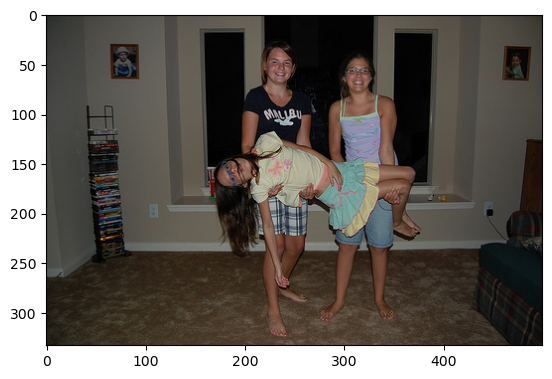

In [73]:
gen_rand_cap()